In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
import random
import pandas as pd

In [3]:
# Chuyển ma trận X bất kì thành array có dạng array([[],[],[],..[]])

def Format1DtoND(X):
    if type(X) == list:
        array_X = np.array(X)
        X_ = array_X.reshape((-1,1))
    elif type(X) == np.ndarray and X.ndim == 1:
        X_ = X.reshape((-1,1))
    elif type(X) == np.ndarray and X.ndim > 1:
        X_ = X
    else:
        X_ = np.array(X)
    return X_

In [4]:
#argmin_{a,b}||aX+b-y|| = argmin_{a,b}||a(X/M)+b/M-y/M||
#Làm giảm biên độ giao động của dữ liệu đưa vào

def ContractionMatric(X,y):
    
    X = Format1DtoND(X)
    y = np.array(y)
    
    norm_X = np.linalg.norm(X)
    norm_y = np.linalg.norm(y)
    
    Coef_Contraction = math.sqrt(max(norm_X,norm_y))
    X_ = 1/Coef_Contraction *X
    y_ = 1/Coef_Contraction *y
    
    return X_,y_,Coef_Contraction

In [5]:
# Tạo random dữ liệu

def CreateData(dimesion_data,size_data =np.random.randint(100,150)):
    
    X = 10*np.random.randn(size_data,dimesion_data)
    a = np.random.randn(1,dimesion_data)
    b = random.randrange(30)
    
    disturb_coef = random.uniform(0.05,1)
    disturb_matric = np.random.randn(size_data)
    
    y = np.dot(a,X.T)[0] +b*np.ones((size_data,1))[0] + disturb_coef*disturb_matric
    
    return X,y

In [6]:
# Phân tích 1 số n_samples thành 2 số n_train, n_test
# sao cho n_samples=n_train+n_test và n_test/n_samples=test_size(cho trước)

def _validate_shuffle_split(n_samples, test_size=None, train_size=None,default_test_size=None):
    
    if test_size is None and train_size is None:
        test_size = default_test_size

    test_size_type = np.asarray(test_size).dtype.kind
    train_size_type = np.asarray(train_size).dtype.kind

    if test_size_type == 'f':
        n_test = math.ceil(test_size * n_samples)
    elif test_size_type == 'i':
        n_test = float(test_size)

    if train_size_type == 'f':
        n_train = math.floor(train_size * n_samples)

    elif train_size_type == 'i':
        n_train = float(train_size)

    if train_size is None:
        n_train = n_samples - n_test

    elif test_size is None:
        n_test = n_samples - n_train

    return n_train, n_test

In [7]:
# Từ 1 list [0,1,...,n_samples-1] phân tích random thành 2 tập con tách rời ind_test, ind_train
# sao cho len(ind_test)=n_test(cho trước), len(ind_train)=n_train(cho trước)

def ShuffleSplit(n_test, n_train, n_samples):
   
    permutation = np.random.permutation(n_samples)
    ind_test = permutation[:n_test]
    ind_train = permutation[n_test:(n_test + n_train)]
    
    return ind_test,ind_train

In [8]:
# Từ hai array X_arrays, y_array tạo random 4 array X_train, X_test, y_train, y_test
# sao cho len(X_train)/len(X_arrays)=len(y_train)/len(y_array)=train_size(cho trước)
# và len(X_test)/len(X_arrays)=len(y_test)/len(y_array)=test_size(cho trước)

def train_test_split(X_arrays, y_array, test_size=None, train_size=None):
    
    X_arrays = Format1DtoND(X_arrays)
    y_array = np.array(y_array)
    n_arrays = len(X_arrays)

    if n_arrays == 0:
        raise ValueError("At least one array required as input")
    else:
        if (test_size != None) and (train_size != None):
            if (test_size + train_size == 1):
                Default_Test_Size = test_size
            else:
                raise ValueError("Sum size of training set and size of testing set must equal 1")
        elif (test_size != None) and (train_size == None):
            Default_Test_Size = test_size
        elif (test_size == None) and (train_size != None):
            Default_Test_Size = 1 - train_size
        else:
            Default_Test_Size = 0.25
            
    n_samples = len(X_arrays)
    n_train, n_test = _validate_shuffle_split(n_samples, test_size, train_size, default_test_size=Default_Test_Size) 
    ind_test,ind_train = ShuffleSplit(n_test=n_test, n_train=n_train,n_samples=n_samples)
    
    X_train = X_arrays[ind_train]
    X_test = X_arrays[ind_test]
    y_train = y_array[ind_train]
    y_test = y_array[ind_test]

    return X_train, X_test, y_train, y_test

In [9]:
# Tạo array Xbar từ array X cho trước bằng cách thêm 1 cột có các phần tử đều là số 1 vào bên trái X

def LeastSquareMatricsConcatenate(X):
    one = np.ones((X.shape[0],1))
    Xbar = np.concatenate((one, X), axis = 1)
    return Xbar

In [10]:
#Tìm gradient theo a,b của hàm cost: .5/N *||X.a+b-y|| tương đương tìm gradient theo w của hàm cost .5/N *||Xbar.w-y||
# với w=[[b] [a]], Xbar=LeastSquareMatricsConcatenate(X)

def GradientLeastSquare(X,y,w):
    Xbar = LeastSquareMatricsConcatenate(X)
    N = Xbar.shape[0]
    return 1/N * Xbar.T.dot(Xbar.dot(w) - y.reshape(-1,1))

In [11]:
def GradientLeastSquare_Contrac(X,y,w):
    Xbar = LeastSquareMatricsConcatenate(X)
    N = Xbar.shape[0]
    D = Xbar.shape[1] - 1
    Matrix_Contraction = np.zeros((D+1,D+1))
    Xbar_trans = Xbar.T
    for i in range(D+1):
        #Matrix_Contraction[i,i] = 1/(math.sqrt(np.linalg.norm(Xbar_trans[i])))
        Matrix_Contraction[i,i] = 1/(np.linalg.norm(Xbar_trans[i]))
    Xbar_new = Xbar.dot(Matrix_Contraction)
    return 1/N * Xbar_new.T.dot(Xbar_new.dot(w) - y.reshape(-1,1))

In [12]:
def Get_Matrix_Contraction(X,y):
    Xbar = LeastSquareMatricsConcatenate(X)
    N = Xbar.shape[0]
    D = Xbar.shape[1] - 1
    Matrix_Contraction = np.zeros((D+1,D+1))
    Xbar_trans = Xbar.T
    for i in range(D+1):
        Matrix_Contraction[i,i] = 1/(np.linalg.norm(Xbar_trans[i]))
    return Matrix_Contraction

In [38]:
#Tìm vector w=[[b],[a]] với a,b là hệ số của linear regression y=aX+b
#Có 4 Format "normal", "momentum", "NAG", "stochastic" nhằm tìm ra vector w, với mỗi Format có 1 đặc điểm riêng

def fit(X_arrays, y_array, eta = 0.1, gamma = 0.9, TOL = 1.e-8, Format = "normal"):
    
    #X_arrays, y_array, Coef_Contraction =  ContractionMatric(X_arrays,y_array)
    X_arrays = Format1DtoND(X_arrays)
    y_array = np.array(y_array)
    
    Matrix_Contraction = Get_Matrix_Contraction(X_arrays,y_array)
    
    N = len(X_arrays[0])
    w_init = np.concatenate((np.ones((1,1)),np.ones((N,1))),axis = 0)
    w =[w_init]
    gradient = GradientLeastSquare_Contrac
    epochs = np.random.randint(100000,110000)
    
    if Format == "normal":
        for it in range(epochs):
            w_new = w[-1] - eta*gradient(X_arrays,y_array,w[-1])
            grad = gradient(X_arrays, y_array, w_new)
            if np.linalg.norm(grad)/len(w_new) < TOL:
                break
            w.append(w_new)
            
    elif Format == "momentum":
        v_old = np.zeros_like(w_init)
        for it in range(epochs):
            v_new = gamma*v_old + eta*gradient(X_arrays,y_array,w[-1])
            w_new = w[-1] - v_new
            grad = gradient(X_arrays, y_array, w_new)
            if np.linalg.norm(grad)/np.array(w_init).size < TOL:
                break
            w.append(w_new)
            v_old = v_new
            
    elif Format == "NAG":
        v = [np.zeros_like(w_init)]
        for it in range(epochs):
            v_new = gamma*v[-1] + eta*gradient(X_arrays, y_array, w[-1] - gamma*v[-1])
            w_new = w[-1] - v_new
            grad = gradient(X_arrays, y_array, w_new)
            if np.linalg.norm(grad)/np.array(w_init).size < TOL:
                break
            w.append(w_new)
            v.append(v_new)
            
    elif Format == "stochastic":
        batch_size = np.random.randint(2,5)
        for it in range(epochs):
            permutation = np.random.permutation(N)
            
            for start in range(0, N, batch_size):
                stop = start + batch_size
                if stop > N:
                    stop = N
                X_per = X_arrays[permutation]
                y_per = y_array[permutation]
                w_new = w[-1] - eta*gradient(X_per,y_per,w[-1])
                if np.all(np.abs(w_new) <= TOL):
                    break
                w.append(w_new)
    w[-1] = Matrix_Contraction.dot(w[-1])
    return w[-1]

In [39]:
# Trả giá trị a=coef và b=intercept của linear regression

def fit_coef_intercept(X_train, y_train, eta=0.1, gamma =0.9, TOL=1.e-8, Format="normal"):
    w = fit(X_train, y_train, eta=eta, gamma=gamma, TOL=TOL, Format=Format)
    b = w[0][0]
    a = w[1:]
    return a,b

In [40]:
# Sau khi tìm được các giá trị coef và intercept của linear regression
# dựa trên các tập X_train, X_test,y_train, y_test ta dự đoán y_train_pred, y_test_pred
# bằng cách: y_train_pred = a.X_train + b, y_test_pred = a.X_test + b

def predict(X_train, X_test,y_train, y_test, eta=0.1, gamma=0.9, TOL=1.e-8, Format="normal"):
    
    a,b = fit_coef_intercept(X_train=X_train, y_train=y_train, eta=eta, gamma=gamma, TOL=TOL, Format=Format)
    
    y_train_pred = a.T.dot(X_train.T) + b*np.ones((len(X_train),1)).T
    y_test_pred = a.T.dot(X_test.T) + b*np.ones((len(X_test),1)).T
    y_train_pred = y_train_pred[0]
    y_test_pred = y_test_pred[0]
    
    return y_train_pred, y_test_pred

In [41]:
# Tính hệ số r2 giữa 2 array y_check và y_pred

def r2_score(y_check,y_pred):
    
    y_pred = np.array(y_pred)
    y_check = np.array(y_check)
    n_check = len(y_check)
    n_pred = len(y_pred)
    
    if (n_check != n_pred):
        raise ValueError("The length of check values and previous values must be equal")
    else:
        N = len(y_check)
        ybar = 1/N * np.sum(y_check)
        vector_tot = y_check - ybar*np.ones_like(y_check)
        vector_res = y_pred - y_check
        
        SS_tot = np.sum(vector_tot*vector_tot)
        SS_res = np.sum(vector_res*vector_res)
        r2 = 1- SS_res/SS_tot
    return r2

In [42]:
def LinearRegressionPlot(X_train, X_test, y_train, y_test, eta = 0.1, gamma = 0.9, TOL = 1.e-8, Format="normal"):
    
    if (type(X_train) == np.ndarray and X_train.ndim == 1) or (type(X_train) == np.ndarray and X_train.ndim > 1 and len(X_train[0])) == 1:
        
        plt.scatter(X_train, y_train, label='training set', color='red')
        plt.scatter(X_test, y_test, label='testing set', color='blue')
        
        a,b = fit_coef_intercept(X_train, y_train, eta=eta, gamma=gamma, TOL=TOL, Format=Format)
        y_train_real = np.dot(a,X_train.T)[0] +b*np.ones((len(X_train),1))[0]
        y_test_real = np.dot(a,X_test.T)[0] +b*np.ones((len(X_test),1))[0]
        
        plt.plot(X_train,y_train_real, color='green', label='LinearRegression')
        plt.plot(X_test,y_test_real, color='green')
        
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        
        plt.legend()
        plt.show()
    else:
        raise ValueError('X must be a array that has one column')
    
    return

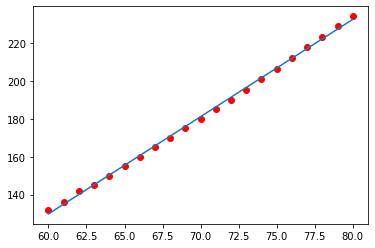

In [43]:
y = np.array([132,136,142,145,150,155,160,165,170,175,180,185,190,195,201,206,212,218,223,229,234])
X = np.array(np.arange(60,81))
w = fit(X, y, eta = 0.05, gamma = 0.9, TOL = 1.e-8, Format = "NAG")
Y = w[1]*X + w[0]
plt.scatter(X,y, color = "red")
plt.plot(X,Y)
plt.show()

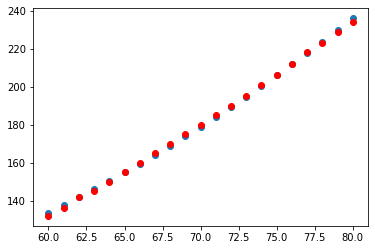

In [46]:
h = np.array(np.arange(60,81))
h_square = (h*h).reshape(-1,1)
h_cube = (h*h*h).reshape(-1,1)
X = np.concatenate((h_square,h_cube),axis = 1)
y = np.array([132,136,142,145,150,155,160,165,170,175,180,185,190,195,201,206,212,218,223,229,234])
w = fit(X, y, eta = 0.05, gamma = 0.9, TOL = 1.e-8, Format = "NAG")
Y = w[0] + w[1]*(h**2) + w[2]*(h**3)
plt.scatter(h,Y)
plt.scatter(h,y, color = "red")
plt.show()

array([ 1,  8, 27], dtype=int32)